In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [ ]:

# Load datasets
orders = pd.read_csv("orders.csv", delimiter=";")
products = pd.read_csv("product_attributes.csv")
cities = pd.read_csv("cities_data.csv", delimiter=";")

In [ ]:
# Merge data
df = orders.merge(products, on="product_id", how="left")
df = df.merge(cities, left_on=["origin_port", "customer"], right_on=["city_from_name", "city_to_name"], how="left")
df.drop(["city_from_name", "city_to_name", "city_from_coord", "city_to_coord"], axis=1, inplace=True)



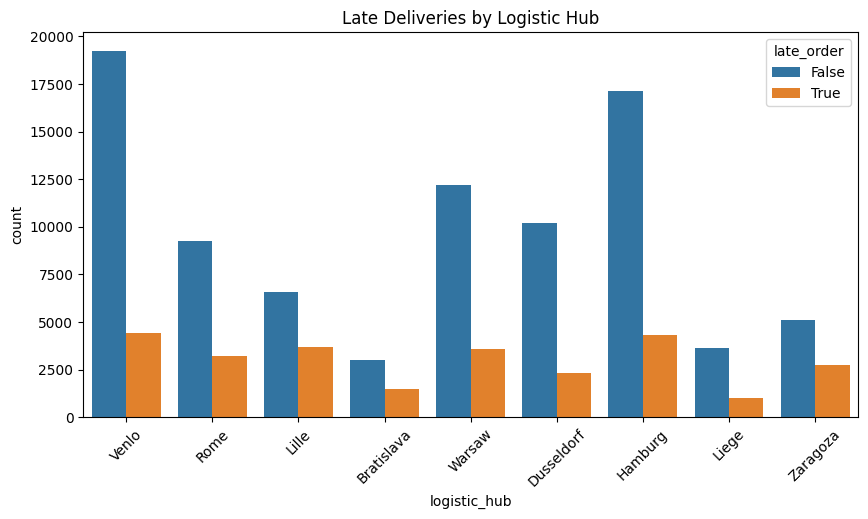

In [ ]:

# EDA
plt.figure(figsize=(10, 5))
sns.countplot(x="logistic_hub", hue="late_order", data=df)
plt.xticks(rotation=45)
plt.title("Late Deliveries by Logistic Hub")
plt.show()


In [ ]:

# Feature selection
features = ["units", "weight", "material_handling", "distance"] + [col for col in df.columns if "3pl_" in col or "logistic_hub_" in col]
X = df[features]
y = df["late_order"]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Handle missing values in all columns
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)  # Impute on training data
X_test_imputed = imputer.transform(X_test)  # Impute on test data

In [ ]:
# Check if there are any missing values after imputation
print(f"Missing values in X_train after imputation:\n{pd.DataFrame(X_train_imputed).isnull().sum()}")
print(f"Missing values in X_test after imputation:\n{pd.DataFrame(X_test_imputed).isnull().sum()}")


Missing values in X_train after imputation:
0    0
1    0
2    0
3    0
dtype: int64
Missing values in X_test after imputation:
0    0
1    0
2    0
3    0
dtype: int64


In [ ]:

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:

# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:

# Predictions
y_pred_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Evaluate using AUC-ROC for Logistic Regression
roc_auc_log = roc_auc_score(y_test, y_pred_prob_log)
print(f"Logistic Regression ROC AUC Score: {roc_auc_log:.3f}")

Logistic Regression ROC AUC Score: 0.597


In [ ]:

# Random Forest Classifier Model with GridSearchCV for Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:

# Best Hyperparameters
print(f"Best Parameters from GridSearchCV: {grid_search.best_params_}")

# Train the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Predictions for Random Forest
y_pred_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

Best Parameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Evaluate using AUC-ROC for Random Forest
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.3f}")


Random Forest ROC AUC Score: 0.760


In [ ]:
# Evaluate the models using Classification Report (Precision, Recall, F1-score)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, log_model.predict(X_test_scaled)))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, best_rf_model.predict(X_test_scaled)))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.77      1.00      0.87     17515
        True       0.89      0.05      0.09      5341

    accuracy                           0.78     22856
   macro avg       0.83      0.52      0.48     22856
weighted avg       0.80      0.78      0.69     22856


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.97      0.88     17515
        True       0.72      0.29      0.41      5341

    accuracy                           0.81     22856
   macro avg       0.77      0.63      0.65     22856
weighted avg       0.79      0.81      0.77     22856



In [ ]:

# Confusion Matrix
log_conf_matrix = confusion_matrix(y_test, log_model.predict(X_test_scaled))
rf_conf_matrix = confusion_matrix(y_test, best_rf_model.predict(X_test_scaled))

print("\nLogistic Regression Confusion Matrix:")
print(log_conf_matrix)

print("\nRandom Forest Confusion Matrix:")
print(rf_conf_matrix)


Logistic Regression Confusion Matrix:
[[17484    31]
 [ 5096   245]]

Random Forest Confusion Matrix:
[[16908   607]
 [ 3806  1535]]


In [ ]:

# Cross-validation for model comparison (Logistic Regression)
log_cross_val_score = cross_val_score(log_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\nLogistic Regression Cross-Validation AUC Scores: {log_cross_val_score}")
print(f"Average AUC: {log_cross_val_score.mean():.3f}")

# Cross-validation for model comparison (Random Forest)
rf_cross_val_score = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Random Forest Cross-Validation AUC Scores: {rf_cross_val_score}")
print(f"Average AUC: {rf_cross_val_score.mean():.3f}")


Logistic Regression Cross-Validation AUC Scores: [0.59296761 0.5950426  0.60490657 0.59290642 0.58436668]
Average AUC: 0.594
Random Forest Cross-Validation AUC Scores: [0.75856795 0.75995919 0.75821051 0.7584396  0.76656023]
Average AUC: 0.760
